In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

# Single model experimentation

One of the critical points of feedback on our process is that we use multiple models.
We use these models to clearly distinguish between the types of variables we're testing: ecosystem contributions (in general, and in (non-)dependent projects) and collaboration metrics.

In part, this was done because variables correlated, thus affecting the model's quality.
This notebook explores how this correlation can be resolved.

Looking at the results of [the revised ecosystem model](./python_proj/modelling/notebooks/single_model_experimentation/ecosystem_model.ipynb), it shows that `ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)` and `ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)` linearly correlate with a Spearman coefficient $\rho$ of $0.748$, which is substantial.

**Goal 1:** The problem that we try to solve in this notebook is to remove this correlation without losing insights.

**Goal 2:** A secondary objective here is to make the metric fully undirectional (w.r.t. directed vs. undirected graphs) as the original metric considered directed $\lambda$-edges and undirected $\mu$-edges.
This likely has no impact of the results as they in- and out-degree correlates strongly, however, optimally, both of these should be undirected.


## Normalized second-order degree centrality

Basic definitions:
- $x, y \in V$ vertices/nodes in the graph.
- $p, q \in P$ projects in the ecosystem.
- $\langle x, y, p \rangle_\lambda$ a $\lambda$-edge connecting nodes $x, y$ in project $p$.
- $E_\lambda(\cdot)$ a set of $\lambda$-edges with some number of constraints applied to them (e.g., who the edge connects to).

We define second-order multi-layer ecosystem node centrality of contributor $x$ in focal project $p$ as:
$$S(x, p) = \sum_{\lambda, \mu}^{L^2}w_\lambda w_\mu \cdot d(x,p,\lambda,\mu)$$
which multiplies the second-order degree centrality of a single pair of layers by multiplying them by their respective weights.

Here, weights are defined as:
$$w_\lambda = \frac{|E_\lambda|}{\sum_{\mu \not = \lambda}^L |E_\mu|}$$

The second-order degree centrality of a single pair of layers is defined as:
$$d(x, p, \lambda, \mu) = \frac{1}{|R_\lambda(x, p)|} \sum^{R_\lambda(x, p)}_{\langle x, y, q \rangle_\lambda} \big(|E_\mu(y)| - |E_\mu(y, x)|\big)$$
such that the first-order degree of all neighbors of $x$ are summed, minus the edges that connect $x$ and $y$.
This sum is then normalized by the number of ecosystem-spanning $\lambda$-edges that $x$ has (i.e., $|R_\lambda(x, p)|$); theoretically, this should remove correlation between the degree of $x$ and their second-order degree centrality.

The ecosystem-spannnig edges of $x$ are then defined as follows:
$$R_\lambda(x, p) = \big\{ \langle x, y, q \rangle_\lambda ~|~ p \not = q \land \langle x, y, q \rangle_\lambda \in E_\lambda(x) \big\}$$
Here, $p$ and $q$ are project identifiers and are used to exclusively include edges that are not part of the focal project; i.e., they are part of the ecosystem.


# Configuration

Defines some experimentation constants.

In [2]:
from pathlib import Path

thread_count = -1
window_size_in_days = 90

output_path = str(
    Path('./data/libraries/npm-libraries-1.6.0-2020-01-12').absolute())
chunk_base_path = str(Path('./data/tmp/data_chunks').absolute()) + "/"
chunk_output_base_path = str(
    Path("./data/tmp/sub_results").absolute()) + "/"

# Data sampling

We can't use pre-calculated data for this project as it lacks details to calculate $R_\lambda$.
Because the sliding window algorithm takes a long time to compute, we sample the last time window from the datasets.
The last time window should have a sufficient number of data points to do this analysis with.

In [3]:
from typing import Dict, Iterator
from datetime import datetime, timedelta
import json

import python_proj.utils.exp_utils as exp_utils
from python_proj.utils.exp_utils import iterate_through_multiple_chronological_issue_pr_datasets


exp_utils.load_paths_for_eco()

# Constants
issue_dataset = "issues_sorted_started_26_05_23_min_5_prs_no_invalid_no_dupes"
pr_dataset = "pulls_sorted_started_26_05_23_min_5_prs_no_invalid_no_dupes"

# Sample window start.
# Copied by running `tail -1` on the pr data file.
last_pr_date = '2020-01-11T23:44:58Z'
last_date = datetime.strptime(last_pr_date, exp_utils.DATETIME_FORMAT)
window_start = last_date - timedelta(days=window_size_in_days)


def create_file_for_final_window(output_path: Path, data_iter: Iterator[Dict]):
    """Creates a dataset for entries within the final time window."""
    with open(output_path, 'w+', encoding='utf-8') as output_file:
        KEY = 'closed_at'
        for entry in data_iter:
            # ensures we don't get a missing key exception
            if KEY not in entry:
                continue

            # ignores everything before the time window starts.
            closed_at = datetime.strptime(
                entry[KEY], exp_utils.DATETIME_FORMAT)
            if closed_at < window_start:
                continue

            jdata = json.dumps(entry)
            output_file.write(f'{jdata}\n')


In [11]:
# Creates data file for issues.
# creates output file for prs
input_issue_dataset_name = 'issues_last_window'
input_pr_dataset = 'prs_last_window'

issue_output_path = Path(exp_utils.CHRONOLOGICAL_DATASET_PATH(
    file_name=input_issue_dataset_name, data_type='issues')).absolute()
issues_iter = iterate_through_multiple_chronological_issue_pr_datasets([
                                                                       issue_dataset], [])
create_file_for_final_window(issue_output_path, issues_iter)


pr_output_path = Path(exp_utils.CHRONOLOGICAL_DATASET_PATH(
    file_name=input_pr_dataset, data_type='pull-requests')).absolute()
pr_iter = iterate_through_multiple_chronological_issue_pr_datasets([], [
                                                                   pr_dataset])
create_file_for_final_window(pr_output_path, pr_iter)

In [4]:

sampled_input_issue_dataset_name = 'issues_last_window_sampled'
sampled_input_pr_dataset = 'prs_last_window_sampled'

In [17]:
import random

# Do the same thin again, but now randomly sample the data.
t = 0.10


def random_sampler(output_path:  str, data_iter: Iterator[Dict]):
    sampled_count = 0
    with open(output_path, 'w+', encoding='utf-8') as output_file:
        for entry in data_iter:
            if random.random() > t:
                continue
            sampled_count += 1
            jdata = json.dumps(entry)
            output_file.write(f'{jdata}\n')
    print(f'Sampled {sampled_count} entries.')

sampled_issue_output_path = Path(exp_utils.CHRONOLOGICAL_DATASET_PATH(
    file_name=sampled_input_issue_dataset_name, data_type='issues')).absolute()
issues_iter = iterate_through_multiple_chronological_issue_pr_datasets([
                                                                       str(Path(issue_output_path).with_suffix("").name)], [])
random_sampler(sampled_issue_output_path, issues_iter)


sampled_pr_output_path = Path(exp_utils.CHRONOLOGICAL_DATASET_PATH(
    file_name=sampled_input_pr_dataset, data_type='pull-requests')).absolute()
pr_iter = iterate_through_multiple_chronological_issue_pr_datasets([], [
                                                                   str(Path(pr_output_path).with_suffix("").name)])
random_sampler(sampled_pr_output_path, pr_iter)

Iterating through 1 datasets: ['/workspaces/msc_thesis/data/libraries/npm-libraries-1.6.0-2020-01-12/issues/issues_last_window.json']
Iterating through 1st chronological data entry.
Iterating through 50001st chronological data entry.
Finished iterating through all 81081 chronological data entries.
Sampled 4147 entries.
Iterating through 1 datasets: ['/workspaces/msc_thesis/data/libraries/npm-libraries-1.6.0-2020-01-12/pull-requests/prs_last_window.json']
Iterating through 1st chronological data entry.
Iterating through 50001st chronological data entry.
Finished iterating through all 88205 chronological data entries.
Sampled 4448 entries.


In [5]:
input_issue_dataset_names = [sampled_input_issue_dataset_name]
input_pr_dataset_names = [sampled_input_pr_dataset]


# Implementation with sliding window algorithm

In [6]:
from python_proj.data_preprocessing.sliding_window_3 import create_sliding_window_dataset
from python_proj.data_preprocessing.sliding_window_features.collaboration_experience.intra_eco_centrality import build_intra_eco_centrality_features
import python_proj.data_preprocessing.sliding_window_features as swf
from networkx import DiGraph
from typing import Tuple, Set, List, Iterable
from itertools import chain, product
from wmutils.collections.safe_dict import SafeDict

from python_proj.data_preprocessing.sliding_window_features.collaboration_experience.intra_eco_centrality import _build_edge_key
from python_proj.data_preprocessing.sliding_window_features import (
    SlidingWindowFeature,
    Feature,
)
from python_proj.data_preprocessing.sliding_window_features.collaboration_experience.centrality_features import SNAFeature
from python_proj.data_preprocessing.sliding_window_features.collaboration_experience.intra_eco_centrality import SNACentralityFeature
import python_proj.utils.exp_utils as exp_utils


class NormalizedSecondOrderEcosystemDegreeCentrality(SNACentralityFeature):
    """
    Note: this is not multi-layer degree centrality.
    That can only be calculated after the fact as it
    requires the total number of included edges for
    each layer. Instead, we return the individual
    values $d(x, p, \lambda, \mu)$.
    """

    def __init__(self, graph: DiGraph, edge_to_project_mapping: dict, edge_types: list[SNAFeature]) -> None:
        super().__init__(graph)
        self._edge_to_project_mapping: dict = edge_to_project_mapping
        self._edge_types = edge_types

    def add_entry(self, *args, **kwargs):
        # This class doesn't process any data entries itself, it relies on the entries of `self._edge_types`.
        return

    def remove_entry(self, *args, **kwargs):
        # This class doesn't process any data entries itself, it relies on the entries of `self._edge_types`.
        return

    def get_name(self) -> Iterator[str]:
        base_name = super().get_name()
        for la, mu in product(self._edge_types, self._edge_types):
            name = f'{base_name}({la.get_name()}.{mu.get_name()})'
            yield name

    def get_feature(self, entry: dict) -> list[int]:
        x = entry["user_data"]["id"]
        repo_path = entry[exp_utils.SOURCE_PATH_KEY]
        p = exp_utils.get_repository_name_from_source_path(repo_path)

        card_R_la, d_la_mu = self.calculate_d_la_mu(x, p)

        results = self.generate_output_vector(card_R_la, d_la_mu)
        return results

    def calculate_d_la_mu(self, x: int, p: str) -> Tuple[Dict[str, int], Dict[str, Dict[str, int]]]:
        card_R_la = SafeDict(default_value=0)
        d_la_mu = SafeDict(SafeDict, default_value_constructor_kwargs={
            'default_value': 0.0})

        # Collects the neighbors from incoming and outgoing edges; i.e., R.
        R = self.get_neighbors(x)
        for y in R:
            E_xy = self.get_edges_between(x, y)

            # Iterates through all edges that connect with the neighbor;
            # This is stil the outer loop.
            for la, T_xy in E_xy:
                for e_t in T_xy:
                    # Filters out edges in the same project.
                    q_key = _build_edge_key(y, x, e_t, la)
                    if q_key in self._edge_to_project_mapping:
                        q = self._edge_to_project_mapping[q_key]
                    else:
                        q_key_2 = _build_edge_key(x, y, e_t, la)
                        q = self._edge_to_project_mapping[q_key_2]
                    if p == q:
                        break

                    # Any element that reaches beyond this point is an element of R_\lambda(x, p).

                    # Updates the counter, used to normalize the entry ($1/|R_\lambda(x, p)|$).
                    card_R_la[la] += 1
                    nb_degree = self.calculate_nb_degree(x, y, e_t)
                    for mu, d in nb_degree.items():
                        d_la_mu[la][mu] += d

        return card_R_la, d_la_mu

    def calculate_nb_degree(self, x: int,  y: int, t: float) -> Dict[str, int]:
        """
        Calculates $e_\mu = (|E_\mu(y)| - |E_\mu(y, x)|)$ differentiating
        between each layer of the graph, for a single neighbor $y$.
        """

        e_mu = SafeDict(default_value=0)
        # Collects the neighbors from incoming and outgoing edges; i.e., R.
        # and removes all entries that are x.
        E = self.get_neighbors(y)
        E = (z for z in E if z != x)
        for z in E:
            E_yz = self.get_edges_between(y, z)
            # Per edge, it retrieves the timed edges, and iterates through those.
            for mu, T_yz in E_yz:
                for e_t in T_yz:
                    # Ignores non-chronological edges.
                    if e_t >= t:
                        continue
                    e_mu[mu] += 1
        return e_mu

    def get_neighbors(self, x: int) -> Set[int]:
        # Collects the neighbors from incoming and outgoing edges; i.e., R.
        # The first element of the in_edge_tuple is the neighbor.
        e_in = self._graph.in_edges(nbunch=[x])
        e_in = ((v, u) for u, v in e_in)
        # The second element of the out_edge tuple is the neighbor.
        e_out = self._graph.out_edges(nbunch=[x])
        nbs = {neighbor_id for _, neighbor_id in chain(e_in, e_out)}
        return nbs

    def get_edges_between(self, x: int, y: int) -> List[Dict]:
        def __helper_get_edges_between() -> Iterable[Tuple[str, Iterable[float]]]:
            """Helper method to iterate through all edges connnecting x and y."""
            E_in = self._graph.get_edge_data(x, y)
            if not E_in is None:
                yield from E_in.items()
            E_out = self._graph.get_edge_data(y, x)
            if not E_out is None:
                yield from E_out.items()

        def __helper_filter_duplicates(edges) -> Iterable[Tuple[str, Iterable[float]]]:
            # NOTE: The implementation of SNAFeature, which this class relies on does not consider duplicate edges.
            # However, these do affect the calculations, so need to be accounted for.
            # Characteristics of a duplicate edge are: same source and target node, same time stamp, same layer.
            # Within the context of this method, this comes down to testing their timestamps.
            for layer, edges in edges:
                exclusion_list = set()
                unique_edges = []
                for edge in edges:
                    if edge in exclusion_list:
                        continue
                    exclusion_list.add(edge)
                    unique_edges.append(edge)
                yield layer, unique_edges

        edges = __helper_get_edges_between()
        edges = __helper_filter_duplicates(edges)
        edges = list(edges)
        return edges

    def generate_output_vector(self, card_R_la: Dict[str, int], d_la_mu: Dict[str, Dict[str, int]]) -> Dict[str, Dict[str, float]]:
        # Normalizes the data and adds it to an output vector.
        out = []
        for la, mu in product(self._edge_types, self._edge_types):
            l = la.get_name()
            m = mu.get_name()
            norm_d_la_mu = d_la_mu[l][m] / (1 + card_R_la[l])
            out.append(norm_d_la_mu)
            if norm_d_la_mu > 0:
                pass
        return out

The following calculates $d(x, p, \lambda, \mu)$ for each tuple $\lambda, \mu$ and outputs those scores to the output file.
These sub-features need to be aggregated into $S(x, p)$ at a later stage in this pipeline.

This implements the feature factory for the sliding window.
It loads the features necessary to populate the multilayer graph, the feature implemented above, and general ecosystem contribution features.
This last one is added so we can test correlation later on.

In [7]:
def feature_factory() -> Tuple[list[SlidingWindowFeature], list[SlidingWindowFeature], list[Feature]]:
    pr_graph_features, issue_graph_features, _ = build_intra_eco_centrality_features()
    graph = pr_graph_features[0]._graph
    edge_to_project_mapping = pr_graph_features[0]._edge_to_project_mapping

    edge_types = list(chain(pr_graph_features, issue_graph_features))

    pr_graph_features.append(
        NormalizedSecondOrderEcosystemDegreeCentrality(graph, edge_to_project_mapping, edge_types))

    eco_se_pr, eco_se_issue = swf.build_eco_se_features()

    issue_sw_features = list(chain(eco_se_issue, issue_graph_features))
    pr_sw_features = list(chain(eco_se_pr, pr_graph_features))

    other_pr = swf.build_other_features()

    # Returns a triple: issue_sw_features, pr_sw_features, pr_features
    return issue_sw_features, pr_sw_features, other_pr

This generates the to-be-evaluated dataset dataset.

In [8]:
create_sliding_window_dataset(output_path, chunk_base_path, chunk_output_base_path, input_issue_dataset_names,
                              input_pr_dataset_names, feature_factory, window_size_in_days, thread_count)

Using output path "/workspaces/msc_thesis/python_proj/modelling/notebooks/single_model_experimentation/data/libraries/npm-libraries-1.6.0-2020-01-12".
Using chunk base path: "/workspaces/msc_thesis/python_proj/modelling/notebooks/single_model_experimentation/data/tmp/data_chunks/".
Using chunk output base path: "/workspaces/msc_thesis/python_proj/modelling/notebooks/single_model_experimentation/data/tmp/sub_results/".
Loaded 11/16 output features:
	Feature 01: (output: True) EcosystemSharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator
	Feature 02: (output: True) EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter
	Feature 03: (output: True) EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter
	Feature 04: (output: False) IssueCommenterToCommenterV2
	Feature 05: (output: False) IssueCommenterToSubmitterV2
	Feature 06: (output: True) EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator
	Feature 07: (out

# Analysis setup

Loads the generated data file and tests for correlation.

In [60]:
import pandas as pd

input_path = r'/workspaces/msc_thesis/python_proj/modelling/notebooks/single_model_experimentation/data/libraries/npm-libraries-1.6.0-2020-01-12'

df: pd.DataFrame = pd.read_csv(input_path, header=0)

df.describe()

,ID,Submitter ID,PR Number,EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator,EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter,EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator,EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter,EcosystemSharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter,NormalizedSecondOrderEcosystemDegreeCentrality(PRIntegratorToSubmitterV2.PRIntegratorToSubmitterV2),NormalizedSecondOrderEcosystemDegreeCentrality(PRIntegratorToSubmitterV2.PRCommenterToSubmitterV2),...,NormalizedSecondOrderEcosystemDegreeCentrality(IssueCommenterToCommenterV2.IssueCommenterToCommenterV2),NormalizedSecondOrderEcosystemDegreeCentrality(IssueCommenterToCommenterV2.IssueCommenterToSubmitterV2),NormalizedSecondOrderEcosystemDegreeCentrality(IssueCommenterToSubmitterV2.PRIntegratorToSubmitterV2),NormalizedSecondOrderEcosystemDegreeCentrality(IssueCommenterToSubmitterV2.PRCommenterToSubmitterV2),NormalizedSecondOrderEcosystemDegreeCentrality(IssueCommenterToSubmitterV2.PRCommenterToCommenterV2),NormalizedSecondOrderEcosystemDegreeCentrality(IssueCommenterToSubmitterV2.IssueCommenterToCommenterV2),NormalizedSecondOrderEcosystemDegreeCentrality(IssueCommenterToSubmitterV2.IssueCommenterToSubmitterV2),EcosystemSharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator,EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter,EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter
count,4.448000e+03,4.448000e+03,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,...,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000
mean,3.360708e+08,9.810179e+06,7291.621628,0.015288,0.006520,0.003597,0.002248,0.022257,0.047460,0.055241,...,0.255278,0.066867,0.005062,0.013603,0.035923,0.089826,0.022425,0.002923,0.001574,0.019110
std,3.326130e+07,1.319174e+07,13341.201930,0.224916,0.142901,0.070244,0.106012,0.735981,0.350907,0.422816,...,4.009005,1.002688,0.081607,0.258510,0.580151,1.707557,0.401671,0.111173,0.065346,0.550849
min,5.008217e+06,1.880000e+02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.317633e+08,8.417455e+05,270.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.410958e+08,4.084538e+06,1426.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.507237e+08,1.329292e+07,5519.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.617756e+08,5.921507e+07,54536.000000,8.000000,5.000000,2.000000,5.000000,31.000000,8.500000,12.000000,...,126.285714,35.428571,3.000000,10.000000,22.000000,84.500000,21.500000,6.000000,3.000000,24.000000


In [61]:
print(df.columns)

Index(['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'SubmitterIsFirstTimeContributor',
       'EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
       'EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator',
       'EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter',
       'EcosystemSharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter',
       'NormalizedSecondOrderEcosystemDegreeCentrality(PRIntegratorToSubmitterV2.PRIntegratorToSubmitterV2)',
       'NormalizedSecondOrderEcosystemDegreeCentrality(PRIntegratorToSubmitterV2.PRCommenterToSubmitterV2)',
       'NormalizedSecondOrderEcosystemDegreeCentrality(PRIntegratorToSubmitterV2.PRCommenterToCommenterV2)',
       'NormalizedSecondOrderEcosystemDegreeCentrality(PRIntegratorToSubmitterV2.Iss

# Feature Aggregation

Aggregates the 25 sub-metrics $d(x, p, \lambda, \mu)$ into $S(x, p)$.

In [62]:
# This is copied from one of the output cells.
edge_counts = {
    "IssueCommenterToCommenterV2": 80400,
    "IssueCommenterToSubmitterV2": 9994,
    "PRIntegratorToSubmitterV2": 2150,
    "PRCommenterToCommenterV2": 41258,
    "PRCommenterToSubmitterV2": 6263
}
total_edges = sum(edge_counts.values())


def calculate_weight(value):
    """Calculates normalized complement of the weight."""
    percentage_complement = 1 - (value / (total_edges))
    normalized_perc_compl = percentage_complement / (len(edge_counts) - 1)
    return normalized_perc_compl


edge_weights = {key: calculate_weight(value)
                for key, value in edge_counts.items()}
total_weight = sum(edge_weights.values())
edge_weights = {key: value / total_weight for key,
                value in edge_weights.items()}

print("Edge weights =", json.dumps(edge_weights, indent=4))

Edge weights = {
    "IssueCommenterToCommenterV2": 0.10649519865776605,
    "IssueCommenterToSubmitterV2": 0.23216185342519544,
    "PRIntegratorToSubmitterV2": 0.2461624959840074,
    "PRCommenterToCommenterV2": 0.17635919037589692,
    "PRCommenterToSubmitterV2": 0.23882126155713418
}


In [63]:
from itertools import product

scopes = ["Ecosystem", "IntraProject"]
edge_types = edge_weights.keys()
directions = ["In", "Out"]
combinations = product(edge_types, edge_types)

BASE_EDGE_FIELD = "NormalizedSecondOrderEcosystemDegreeCentrality({connecting_edge}.{experience_edge})"
TARGET_FIELD = "NormalizedSecondOrderEcosystemDegreeCentrality"

centrality_features = []

# Iterates through all edge variables.
for connecting_edge, experience_edge in combinations:
    edge_field = BASE_EDGE_FIELD.format(
        connecting_edge=connecting_edge,
        experience_edge=experience_edge,
    )

    # Applies the weights to edge.
    connecting_weight = edge_weights[connecting_edge]
    experience_weight = edge_weights[experience_edge]
    total_weight = connecting_weight * experience_weight

    df[edge_field] = df[edge_field].multiply(total_weight)

    # Add contribution to centrality.
    # target_field = BASE_TARGET_FIELD.format(scope=scope, direction=direction)
    # Sets initial value if it doesn't exist yet.
    if TARGET_FIELD not in df.columns:
        df[TARGET_FIELD] = 0
        centrality_features.append(TARGET_FIELD)

    df[TARGET_FIELD] = df[TARGET_FIELD].add(df[edge_field])

    # Drops the edge column, as it's only necessary once.
    df = df.drop(edge_field, axis=1)

print(f"{len(df.columns)=}")
df[centrality_features].describe()

len(df.columns)=16


,NormalizedSecondOrderEcosystemDegreeCentrality
count,4448.000000
mean,0.324685
std,1.772412
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,23.694199


# Transforming and scaling

Applies add-one log transform to the data, removes outliers using cook's distance, and then applies min-max scaling to the leftover data.

In [64]:
# applies add-one log transform

import numpy as np

ln_key = "ln(1 + {field})"

df: pd.DataFrame = df

num_fields = df[df.columns[5:]].select_dtypes(include='number').columns

for column in num_fields:
    new_field = ln_key.format(field=column)
    df[new_field] = df[column].add(1).apply(np.log)

df = df.drop(num_fields, axis=1)

In [65]:
# applies min-max scale

def scale(_df: pd.DataFrame, scaled_fields: pd.Series):
    scaled_df = _df.copy()

    for feature in scaled_fields:
        feature_min = scaled_df[feature].min()
        feature_max = scaled_df[feature].max()
        feature_delta = feature_max - feature_min

        scaled_df[feature] = (
            scaled_df[feature].subtract(feature_min).divide(feature_delta)
        )

    return scaled_df

num_fields = df[df.columns[5:]].select_dtypes(include='number').columns
df = scale(df, num_fields)


In [66]:
df.describe()

,ID,Submitter ID,PR Number,ln(1 + EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter),ln(1 + EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator),ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + EcosystemSharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemSharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator),ln(1 + EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality)
count,4.448000e+03,4.448000e+03,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000
mean,3.360708e+08,9.810179e+06,7291.621628,0.003594,0.001682,0.002093,0.000450,0.001082,0.000625,0.000562,0.001321,0.031825
std,3.326130e+07,1.319174e+07,13341.201930,0.042016,0.035824,0.039565,0.021202,0.028551,0.021938,0.022487,0.030539,0.127499
min,5.008217e+06,1.880000e+02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.317633e+08,8.417455e+05,270.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.410958e+08,4.084538e+06,1426.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.507237e+08,1.329292e+07,5519.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.617756e+08,5.921507e+07,54536.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Correlation testing

Uses VIF and Spearman correlation to identify problematically multicollinear features.

## VIF

Calculates variance inflation factor to identify problematic multicollinearity.

In [67]:
df = df[df.columns[6:]]

df.describe()

,ln(1 + EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter),ln(1 + EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator),ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + EcosystemSharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemSharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator),ln(1 + EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality)
count,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000
mean,0.003594,0.001682,0.002093,0.000450,0.001082,0.000625,0.000562,0.001321,0.031825
std,0.042016,0.035824,0.039565,0.021202,0.028551,0.021938,0.022487,0.030539,0.127499
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
# Replaces binary values with numeric variants so VIF can be calculated.

from statsmodels.stats.outliers_influence import variance_inflation_factor

value_mapper = {False: 0, True: 1}

binary_fields = df.select_dtypes(exclude="number")
print(f"{len(binary_fields.columns)=}")
for feature in binary_fields:
    df[feature] = df[feature].replace(value_mapper)

len(binary_fields.columns)=1


In [69]:
# Calculates VIF

vif_df = pd.DataFrame()
vif_df["variable"] = df.columns
vif_df["VIF"] = [
    variance_inflation_factor(df.values, i) for i in range(df.shape[1])
]

print(vif_df)

                                            variable       VIF
0                    SubmitterIsFirstTimeContributor  1.037280
1  ln(1 + EcosystemSharedExperiencePullRequestSub...  2.324803
2  ln(1 + EcosystemSharedExperiencePullRequestSub...  1.949525
3  ln(1 + EcosystemSharedExperiencePullRequestSub...  2.258287
4  ln(1 + EcosystemSharedExperiencePullRequestSub...  2.549632
5  ln(1 + EcosystemSharedExperiencePullRequestDis...  3.944735
6  ln(1 + EcosystemSharedExperienceIssueSubmitted...  4.714361
7  ln(1 + EcosystemSharedExperienceIssueSubmitted...  1.416723
8  ln(1 + EcosystemSharedExperienceIssueDiscussio...  5.284488
9  ln(1 + NormalizedSecondOrderEcosystemDegreeCen...  1.112120


In [70]:
# Identifies problematic fields, according to VIF.

VIF_THRESHOLD = 5

problematic_vif = vif_df[vif_df["VIF"] >= VIF_THRESHOLD]

print(f"{VIF_THRESHOLD}")
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:\n", problematic_vif)

5
Problematic VIF fields: 1.
Problematic VIF scores:
                                             variable       VIF
8  ln(1 + EcosystemSharedExperienceIssueDiscussio...  5.284488


## Spearman correlation

Calculates pairwise correlation to identify multicollinear variables

In [75]:
# Calculates Spearman correlation between variables.

import json

corr = df.corr(method="spearman")
coof_threshold = 0.5
print(f"{coof_threshold=}")

correlating_fields = []
for rowIndex, row in corr.iterrows():
    for columnIndex, coof in row.items():
        if columnIndex <= rowIndex:
            continue
        if abs(coof) < coof_threshold:
            continue
        correlating_fields.append([columnIndex, rowIndex, coof])
correlating_fields = [list(entry) for entry in correlating_fields]

print("Correlating pairs:\n", json.dumps(correlating_fields, indent=2))

coof_threshold=0.5
Correlating pairs:
 [
  [
    "ln(1 + EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)",
    "ln(1 + EcosystemSharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)",
    0.6859305464057908
  ],
  [
    "ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + EcosystemSharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)",
    0.5003374641001722
  ],
  [
    "ln(1 + EcosystemSharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)",
    "ln(1 + EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter)",
    0.6328113093321175
  ]
]


In [72]:
# Generates transitive closure of correlating fields;
# i.e., it identifies clusters of correlating features.

from typing import List, Set

transitive_closures: List[Set[str]] = []

# Iterates through all correlating fields.
for field_a, field_b, _ in correlating_fields:
    was_added = False
    # Sees if one of the components is part of a transitive closure.
    for transitive_closure in transitive_closures:
        if field_a in transitive_closure or field_b in transitive_closure:
            was_added = True
            transitive_closure.update((field_a, field_b))
    # Adds new closure if they are not.
    if not was_added:
        new_set = set()
        new_set.update((field_a, field_b))
        transitive_closures.append(new_set)

# Prepares the closures to be printed.
transitive_closures = [sorted(list(closure)) for closure in transitive_closures]

print(
    "Transitive closure of correlating pairs:\n",
    json.dumps(transitive_closures, indent=2),
)

Transitive closure of correlating pairs:
 [
  [
    "ln(1 + EcosystemSharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)",
    "ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)",
    "ln(1 + EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)",
    "ln(1 + EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)"
  ],
  [
    "ln(1 + EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter)",
    "ln(1 + EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + EcosystemSharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)"
  ]
]


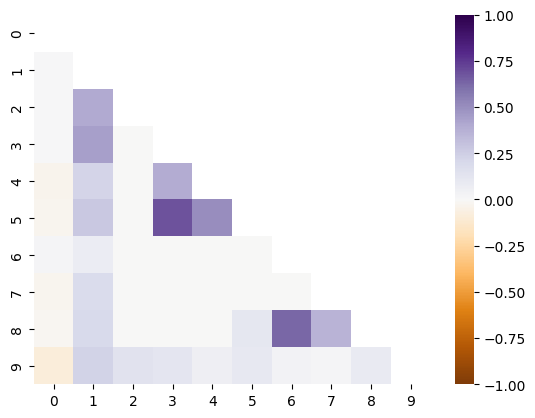

In [73]:
# Plots correlation as seaborn plot.

import seaborn as sb

tick_labels = list(range(len(vif_df)))
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(
    corr,
    cmap="PuOr",
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    mask=mask,
    vmin=-1,
    vmax=1,
)

[[0, "SubmitterIsFirstTimeContributor"], [1, "ln(1 + EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)"], [2, "ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)"], [3, "ln(1 + EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)"], [4, "ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)"], [5, "ln(1 + EcosystemSharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)"], [6, "ln(1 + EcosystemSharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)"], [7, "ln(1 + EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)"], [8, "ln(1 + EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter)"], [9, "ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality)"]]


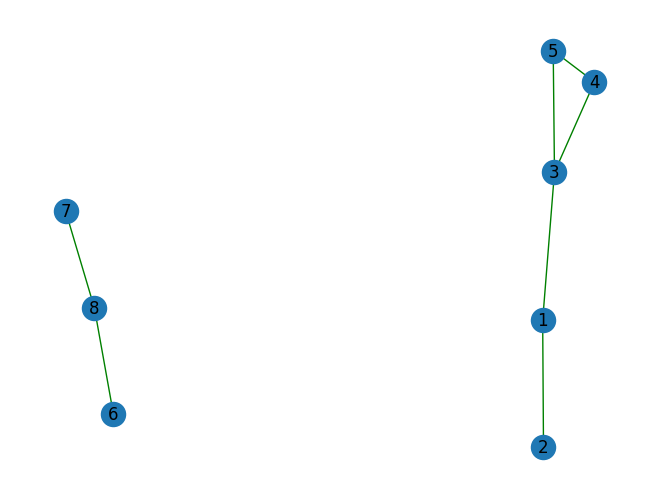

In [74]:
# Plots correlations as a graph.

import networkx as nx

fields = list(df.columns)
enumerated_list = list(enumerate(fields))
ids = []
edge_colors = []
for source, target, coof in correlating_fields:
    source_idx = fields.index(source)
    target_idx = fields.index(target)
    ids.append((source_idx, target_idx))
    edge_colors.append("red" if coof < 0 else "green")

# Create an empty graph
graph = nx.Graph()

# Add edges to the graph from the list of tuples
graph.add_edges_from(ids)

pos = nx.spring_layout(graph, k=0.4)
nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)

if len(correlating_fields) == 0:
    print("When there are no correlating fields, the figure is supposed to be empty.")

print(json.dumps(enumerated_list))